In [2]:
!pip install pydicom


Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [1]:
import os
import pydicom
import pandas 
from pathlib import Path
from collections import defaultdict


In [2]:
from tqdm import tqdm
from concurrent.futures import ThreadPoolExecutor

root_dir = Path("/home/mitirev/ADNI")
dcm_paths = list(root_dir.rglob("*.dcm"))

def load_dicom(path):
    try:
        ds = pydicom.dcmread(path)
        parts = path.relative_to(root_dir).parts
        if len(parts) < 5:
            return None
        return {
            "path": str(path),
            "patient_id": parts[0],
            "preprocessing": parts[1],
            "date": parts[2],
            "study_id": parts[3],
            "dicom": ds
        }
    except Exception as e:
        return None

# Use ThreadPoolExecutor for concurrent loading
with ThreadPoolExecutor(max_workers=8) as executor:
    dicom_data = []
    # Wrap the iterable dcm_paths with tqdm to show progress
    for result in tqdm(executor.map(load_dicom, dcm_paths), total=len(dcm_paths), desc="Loading DICOMs"):
        if result:
            dicom_data.append(result)


Loading DICOMs: 100%|██████████████████████████████████████████████████████████| 179136/179136 [06:21<00:00, 470.13it/s]


Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 214
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: Positron Emission Tomography Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.3.6.1.4.1.13856.242000.1.2.1112.5.717087167610.1841
(0002, 0010) Transfer Syntax UID                 UI: Explicit VR Little Endian
(0002, 0012) Implementation Class UID            UI: 2.16.840.1.114226
(0002, 0013) Implementation Version Name         SH: 'IDL_2.1.0_3.4.0'
(0002, 0016) Source Application Entity Title     AE: 'RSI_IDL_DICOMEX'
-------------------------------------------------
(0008, 0000) Group Length                        UL: 502
(0008, 0008) Image Type                          CS: ['DERIVED', 'PRIMARY']
(0008, 0016) SOP Class UID                       UI: Positron Emission Tomography Image Storage
(0008, 0018) SOP Instance UID                    UI: 1

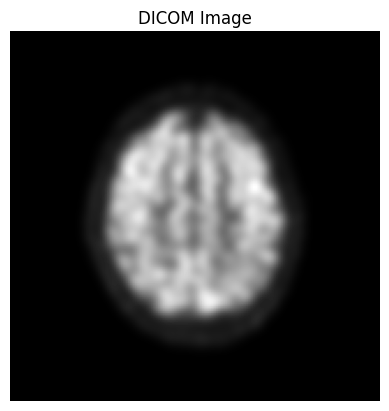

In [3]:
from pydicom import Dataset
import matplotlib.pyplot as plt

ds = Dataset()

# Path to your local DICOM file
file = dicom_data[800].get("dicom")

# Read the file
#dicom_file = pydicom.dcmread(file_path)

# Print info
print(file)


# Display the image
plt.imshow(file.pixel_array, cmap=plt.cm.gray)
plt.title("DICOM Image")
plt.axis('off')
plt.show()



In [9]:
# Extract and preprocess pixel array
import numpy as np
from PIL import Image
from torchvision import transforms


pixel_array = file.pixel_array.astype(np.float32)

# Normalize (min-max normalization to 0-1)
pixel_array -= pixel_array.min()
pixel_array /= pixel_array.max()

# Convert to PIL for resizing if needed
image = Image.fromarray((pixel_array * 255).astype(np.uint8))

# Resize to model input size (e.g., 64x64 for VQ-VAE)
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),  # Converts to tensor in [0,1], shape [C, H, W]
])